# Unsupervised "Normality" Detection with Density Estimation

## Preparing the environment

Imports we'll need

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Open the file. Mind the size. 

In [2]:
FILE = 'Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data.csv'

In [3]:
!ls -lh $FILE

"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Load file (may take minutes). 

In [4]:
%%time
frm = pd.read_csv(FILE)

Wall time: 4min 19s


This dataset contains information of (x,y)-tracks of vehicles as they passed through highway segments. The trajectories were obtained with a computer vision algorithm which detects vehicles and tracks them. 

Each row of the data contains the ID of a vehicle, a timestamp, x and y coordinates, attributes of the vehicle and some other inferred attributes, among others. 

In [ ]:
frm.columns

Index(['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Global_Time', 'Local_X',
       'Local_Y', 'Global_X', 'Global_Y', 'v_length', 'v_Width', 'v_Class',
       'v_Vel', 'v_Acc', 'Lane_ID', 'O_Zone', 'D_Zone', 'Int_ID', 'Section_ID',
       'Direction', 'Movement', 'Preceding', 'Following', 'Space_Headway',
       'Time_Headway', 'Location'],
      dtype='object')

## Detecting "usual" and "unusual" patterns with "Manual" Density Estimation

First, let's examine the height and witdth of the detected vehicles. Since each vehicle appears as many times as "trajectory" points it has, we get the first row of each "Vehicle_ID". 

In [2]:
%%time
#f = frm.groupby('Vehicle_ID').first()
f = pd.read_csv('vehicles.csv')

Wall time: 781 ms


In [3]:
f.head()

,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,...,D_Zone,Int_ID,Section_ID,Direction,Movement,Preceding,Following,Space_Headway,Time_Headway,Location
0,838,569,1118847925800,56.932,2166.789,6452671.544,1871917.593,47.0,8.5,3,...,NaN,NaN,NaN,NaN,NaN,0,16,0.0,0.0,us-101
1,6,1707,1163030900,43.585,220.364,2230573.265,1375744.825,14.0,7.0,2,...,214.0,0.0,0.0,3.0,1.0,0,0,0.0,0.0,peachtree
2,869,661,1118847928900,30.207,2168.874,6452689.832,1871937.192,16.5,6.4,2,...,NaN,NaN,NaN,NaN,NaN,0,7,0.0,0.0,us-101
3,4,226,1163030700,37.654,2028.219,2230833.519,1377492.900,12.8,7.4,2,...,215.0,5.0,0.0,3.0,1.0,0,0,0.0,0.0,peachtree
4,158,155,1163046100,32.721,681.333,2230607.631,1376204.990,15.1,6.6,2,...,203.0,0.0,0.0,1.0,1.0,0,0,0.0,0.0,peachtree


First, let's plot vehicle dimensions: 

Text(0,0.5,'Vehicle Height')

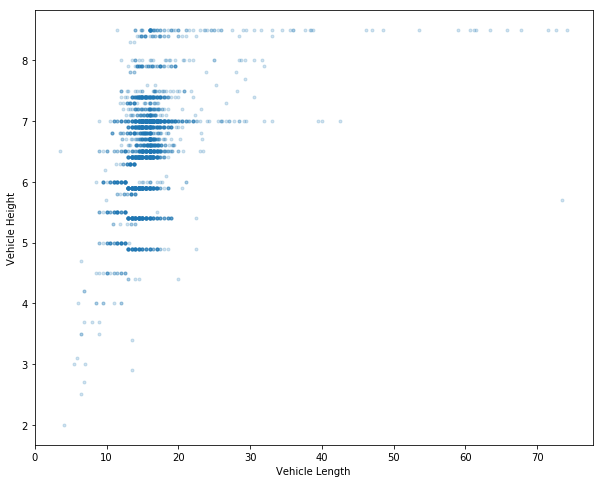

In [4]:
plt.figure(figsize=(10,8))
plt.scatter(f.v_length, f.v_Width, alpha=0.2, marker='.')
plt.xlabel('Vehicle Length')
plt.ylabel('Vehicle Height')

It seems there is an area which 'concentrates' many points. These typically correspond to the most popular types of vehicles ("normal" cars?). The rest should correspond to other types of vehicles, or even errors of the tracking algorithm. 

If we analyze length and width independently:

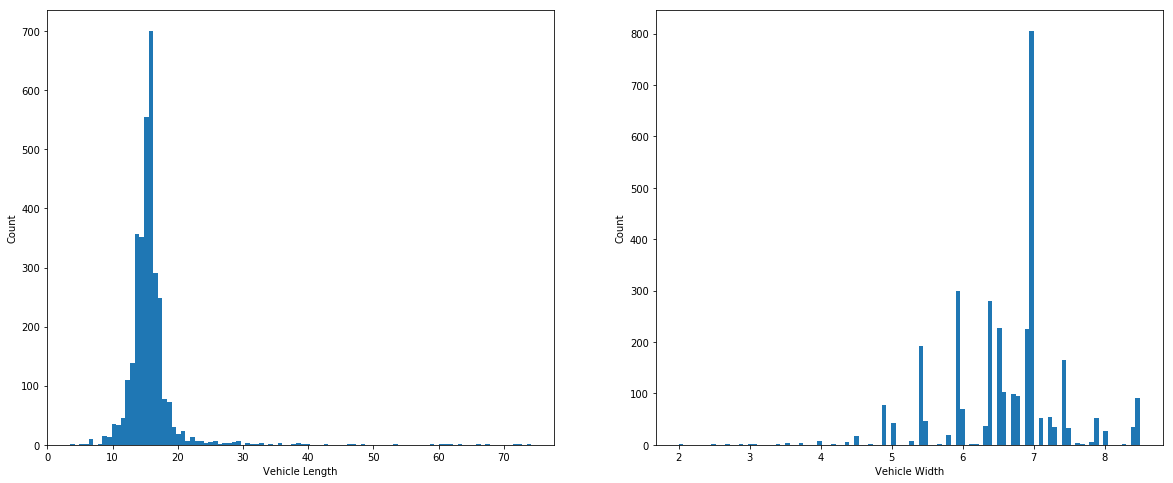

In [5]:
figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,8))
_ = axes[0].hist(f.v_length, bins=100)
_ = axes[1].hist(f.v_Width, bins=100)
_ = axes[0].set_xlabel('Vehicle Length')
_ = axes[1].set_xlabel('Vehicle Width')
_ = axes[0].set_ylabel('Count')
_ = axes[1].set_ylabel('Count')

Another plot I like is feature vs .percentile

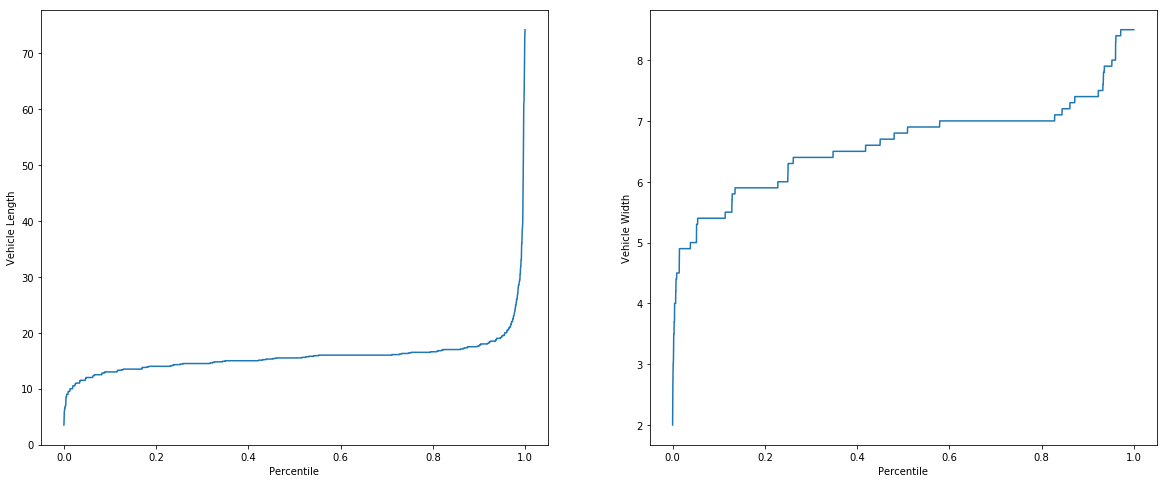

In [6]:
def percentile_plot(axis, col, str):
    y = col.sort_values().values
    x = np.arange(0, len(y))/len(y)
    axis.plot(x, y)
    _ = axis.set_ylabel(str)
    _ = axis.set_xlabel('Percentile')

figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,8))
percentile_plot(axes[0], f.v_length, 'Vehicle Length')
percentile_plot(axes[1], f.v_Width, 'Vehicle Width')

In [ ]:
#Mirar interact - 

interactive(children=(IntSlider(value=10, description='min_length', max=30, min=-10), IntSlider(value=20, desc…

<function __main__.explore(min_length, max_length, min_width, max_width)>

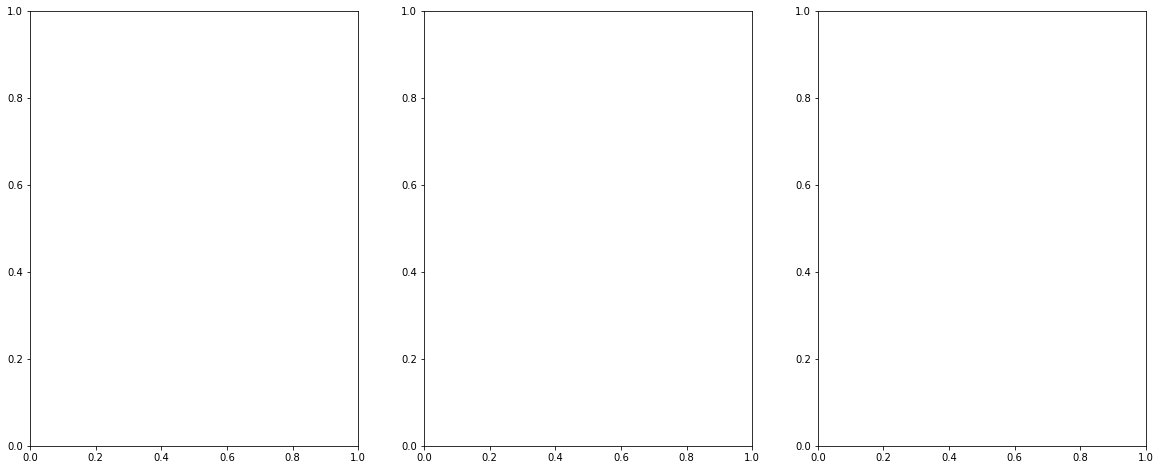

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def explore(min_length, max_length, min_width, max_width):
    figure, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,8))
    percentile_plot(axes[0], f.v_length, 'Vehicle Length')
    percentile_plot(axes[1], f.v_Width, 'Vehicle Width')

    axes[0].plot([0,1], [min_length]*2, 'r--')
    axes[0].plot([0,1], [max_length]*2, 'r--')

    axes[1].plot([0,1], [min_width]*2, 'r--')
    axes[1].plot([0,1], [max_width]*2, 'r--')

    axes[2].scatter(f.v_length, f.v_Width, alpha=0.2, marker='.')
    axes[2].plot([f.v_length.min(), f.v_length.max()], [min_width]*2, 'r--')
    axes[2].plot([f.v_length.min(), f.v_length.max()], [max_width]*2, 'r--')
    axes[2].plot([min_length]*2, [f.v_Width.min(), f.v_Width.max()], 'r--')
    axes[2].plot([max_length]*2, [f.v_Width.min(), f.v_Width.max()], 'r--')
    axes[2].set_xlabel('Vehicle length')
    axes[2].set_ylabel('Vehicle width')
    
    
interact(explore, min_length=10, max_length=20, min_width=6.35, max_width=7.4)
#explore(min_length=10, max_length=20, min_width=6.35, max_width=7.4)

## Kernel Density Estimation

Now try with kernel density estimation. 

In [8]:
from sklearn.neighbors import KernelDensity

X = np.vstack([f.v_length.values, f.v_Width.values]).T
kd = KernelDensity(kernel='linear', bandwidth=1.2, )
kd.fit(X)

KernelDensity(algorithm='auto', atol=0, bandwidth=1.2, breadth_first=True,
       kernel='linear', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

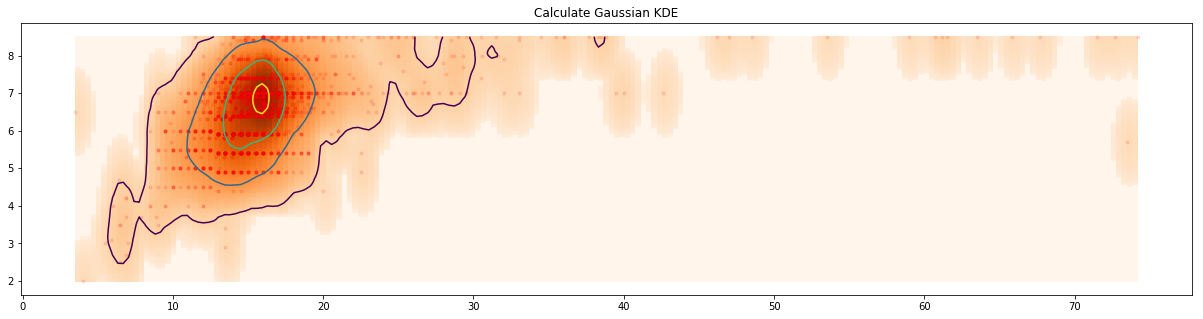

In [9]:
NBINS = 200
xi, yi = np.mgrid[f.v_length.min():f.v_length.max():NBINS*1j, f.v_Width.min():f.v_Width.max():NBINS*1j]
zi = np.exp(0.25*kd.score_samples(np.vstack([xi.flatten(), yi.flatten()]).T))
# plot a density
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(21, 5))
axes.set_title('Calculate Gaussian KDE')
axes.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap="Oranges")
axes.contour(xi, yi, zi.reshape(xi.shape), 5)
plt.scatter(X[:,0], X[:,1], color="Red", alpha=0.1, marker='.')

We can compute the "density" at each data point.

In [10]:
level = np.exp(kd.score_samples(f[['v_length', 'v_Width']].values))

And, for instance, plot in different colors the samples above / below density. 

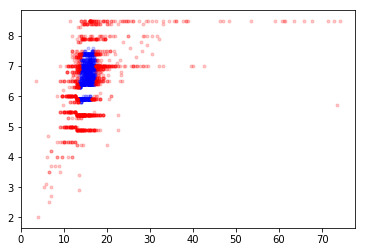

In [11]:
above_level = level >= 0.04
below_level = level < 0.04

plt.scatter(f.v_length.values[above_level], f.v_Width.values[above_level], color="Blue", alpha=0.2, marker='.')
plt.scatter(f.v_length.values[below_level], f.v_Width.values[below_level], color="Red", alpha=0.2, marker='.')

## What is it doing? 

Take a 1-D example and visualize what KD does 

1. point-per-point
2. over all points

Text(0,0.5,'Density')

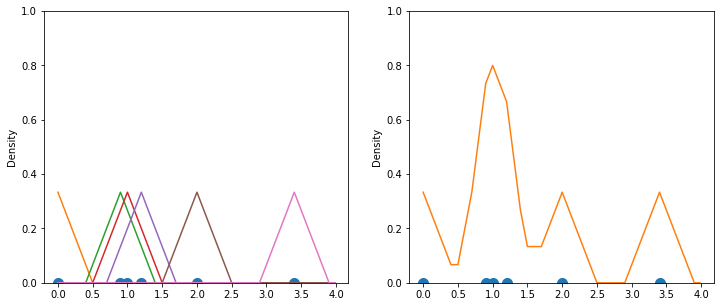

In [16]:
simple = np.array([0, 0.9, 1, 1.2, 2, 3.4])
xgrid = np.arange(0, 4, 0.02)[:,None]

bw = 0.5
figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
axes[0].plot(simple, np.zeros_like(simple), 'o', markersize=10)
axes[1].plot(simple, np.zeros_like(simple), 'o', markersize=10)
axes[0].set_ylim([0, 1.0])
axes[1].set_ylim([0, 1.0])
kd = KernelDensity(kernel='linear', bandwidth=bw)

# Point per point
for x in simple: 
    xa = np.array([[x]])
    kd.fit(xa)
    axes[0].plot(xgrid, 1/simple.shape[0]*np.exp(kd.score_samples(xgrid)))
    axes[0].set_ylabel('Density')

# For all points
kd.fit(simple[:,None])
density = np.exp(kd.score_samples(xgrid))
axes[1].plot(xgrid, density)
axes[1].set_ylabel('Density')

If we had plotted it as a 1D heatmap:

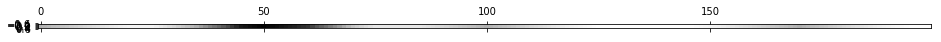

In [17]:
plt.matshow(density[:,None].T, cmap="Greys")

Different types of kernels

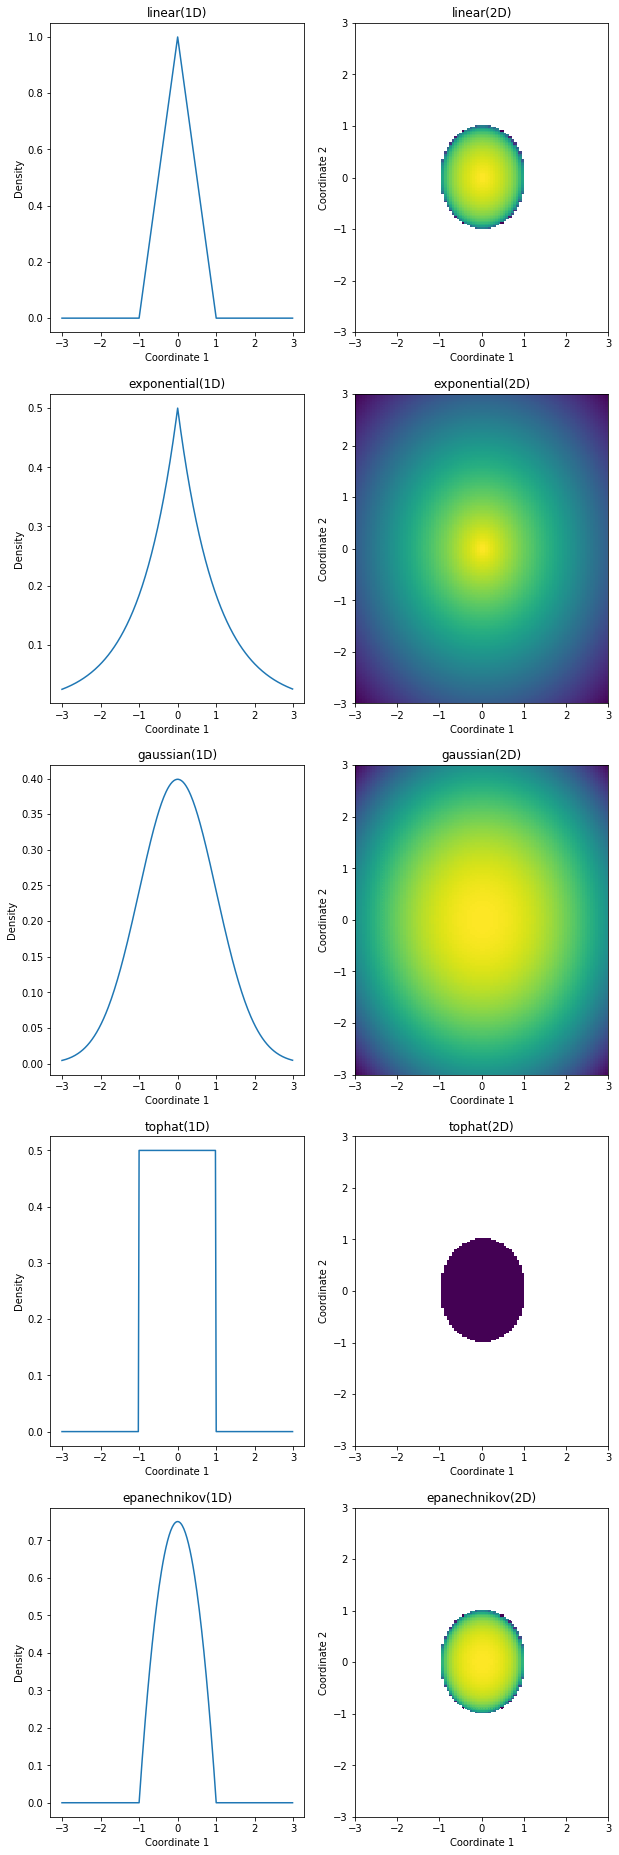

In [18]:
def plot_kernel(ax, idx, kernel_name):
    
    # 1D case
    x = np.array([[0]])
    xgrid = np.arange(-3,3,0.02)[:, None]
    kd = KernelDensity(kernel=kernel_name, bandwidth=1, )
    kd.fit(x)
    levels = np.exp(kd.score_samples(xgrid))
    ax[idx,0].plot(xgrid, levels)
    ax[idx,0].set_title(kernel_name + "(1D)")
    ax[idx,0].set_xlabel('Coordinate 1')
    ax[idx,0].set_ylabel('Density')
    
    # 2D case
    xy = np.array([[0, 0]])
    kd = KernelDensity(kernel=kernel_name, bandwidth=1, )
    kd.fit(xy)
    xi, yi = np.mgrid[-3:3:100*1j, -3:3:200*1j]
    zi = kd.score_samples(np.vstack([xi.flatten(), yi.flatten()]).T)
    ax[idx,1].pcolormesh(xi, yi, zi.reshape(xi.shape))
    ax[idx,1].set_title(kernel_name + "(2D)")
    ax[idx,1].set_xlabel('Coordinate 1')
    ax[idx,1].set_ylabel('Coordinate 2')


kernels = ['linear', 'exponential', 'gaussian', 'tophat', 'epanechnikov']
figure, axes = plt.subplots(ncols=2, nrows=len(kernels), figsize=(10, 33))

for i in range(0, len(kernels)):
    plot_kernel(axes, i, kernels[i])